# Evaluating robustness of cluster assignments with sparse datasets (Figure 3)

This notebook generates barplots for prediction and interpolation (sparsity) experiments - uses calculated error from [this script](sparsity_prediction_process.py)

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
from analysis_utils import *

import joblib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path 
from statannot import add_stat_annotation
import seaborn as sns
from scipy.stats import wilcoxon



sns.set(font_scale=2.5, style="white", color_codes=False)

In [3]:
def process_err_df(mod_obj):
    """Convert ModelSum object to pandas dataframe summarizing info"""
    df = pd.DataFrame()
    for key in mod_obj.keys():
        curdf = pd.DataFrame(mod_obj[key].err, columns=['err']).dropna()
        curdf['task_num'] = mod_obj[key].task_num
        curdf['seed'] = mod_obj[key].seed
        curdf['type'] = mod_obj[key].mod_type
        curdf['best_ll']=mod_obj[key].best_ll
        df = df.append(curdf)
    return(df)        

def process_num_clust(mod_obj):
    """Get number of clusters in model"""
    df = pd.DataFrame(columns=['num_clust', 'best_ll', 'neg_best_ll', 'task_num', 'seed', 'type'])
    for key in mod_obj.keys():
        df.loc[key] = pd.Series({'num_clust':mod_obj[key].num_clust, 'best_ll':mod_obj[key].best_ll, 'neg_best_ll':-mod_obj[key].best_ll, 'task_num':mod_obj[key].task_num, 'seed':mod_obj[key].seed, 'type': mod_obj[key].mod_type})
    return(df)
            
def gen_err_merge(mod_obj_dict):
    """For best MAP seeds, get number of clusters and error"""
    df_cn_merge = pd.DataFrame()
    df_err_merge = pd.DataFrame()
    
    for key in mod_obj_dict.keys():
        df_cn_merge = df_cn_merge.append(process_num_clust(mod_obj_dict[key]))
        df_err_merge = df_err_merge.append(process_err_df(mod_obj_dict[key]))  
    return(df_err_merge, df_cn_merge)

In [4]:
def plot_bars_cn(ax, df_err_merge, err_col, plot_title, legend_labels, axtitle=None, ylim=None, col_palette=None):
    """Plotting function for cluster numbers"""
    df_err_merge = df_err_merge.copy()
    df_err_merge['type'] = df_err_merge['type'].map(legend_labels)
    sns.barplot(ax=ax, x='task_num', y=err_col, hue='type',data=df_err_merge, palette=col_palette, edgecolor=".2", linewidth=2.5,  saturation=1)

    sns.despine(top=True)
    ax.set(xlabel=plot_title, ylabel='Number of Clusters')
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.set_title(axtitle, loc='left', pad=60, fontweight="bold")
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    return ax, handles, labels


In [5]:
def calc_wilcoxon(df, box_pairs):
    annot = []
    for pair in box_pairs:
        bp_1 = df[(df['task_num']==pair[0][0])&(df['type']==pair[0][1])]
        bp_2 = df[(df['task_num']==pair[1][0])&(df['type']==pair[1][1])]
        comp_stat, comp_pval = wilcoxon(bp_1['err'], bp_2['err'], alternative='less')
        annot.append('p={:.2e}'.format(comp_pval))
    return(annot)

In [6]:
def plot_bars_task(ax, df_err_merge, err_col, plot_title, legend_labels, axtitle=None, ylim=None, yticks=None, col_palette=None, axpad=105):
    """Plotting function for prediction/sparsity barplot"""
    df_err_merge = df_err_merge.copy()
    df_err_merge['type'] = df_err_merge['type'].map(legend_labels)
#     sns.barplot(ax=ax, x='task_num', y=err_col, hue='type',data=df_err_merge, palette=col_palette, edgecolor=".2", linewidth=2.5,  saturation=1)
    sns.boxplot(ax=ax, x='task_num', y=err_col, hue='type',data=df_err_merge, palette=col_palette,linewidth=2.5,  saturation=1)
    
    sns.despine(top=True)
    ax.set_xlabel(plot_title)
    ax.set_ylabel('Error \n(Sq. Rt. ALSFRS-R)', fontsize=30)
    if ylim is not None:
        ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticks(yticks)

    kernel_types = list(df_err_merge['type'].dropna().unique())  
    box_pairs = []
    for kern_i in range(1, len(kernel_types)):
        box_pairs = box_pairs + [((x, kernel_types[0]), (x, kernel_types[kern_i])) for x in df_err_merge['task_num'].unique()]  


    cust_annot = calc_wilcoxon(df_err_merge, box_pairs)
    test_results = add_stat_annotation(ax, x='task_num', y=err_col, hue='type', data=df_err_merge,
                                   box_pairs=box_pairs, text_annot_custom = cust_annot,
                                   test='Wilcoxon', stats_params={'alternative':'less'}, fontsize=20,
                                   loc='outside', verbose=2, comparisons_correction=None)
    
    ax.set_title(axtitle, loc='left', pad=axpad, fontweight="bold")
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    return ax, handles, labels


In [7]:
# Load all data matrices
exp_path = Path('data/model_data/2_sparsity_prediction')
# base_mods = ['rbf', 'slope', 'linear']
base_mods = ['rbf', 'slope', 'linear', 'sigmoid', 'gp', 'quad', 'lme']


file_ext_dict = {'prediction': 'predict', 'sparsity':'sparse'}
err_store_dict = {}

for cur_exp in ['prediction', 'sparsity']:        
    rmse_err_path = exp_path / cur_exp / 'results' / 'rmse' 
    for cur_proj in ['ceft', 'proact']:
        tmp_store_dict = {}
        for cur_mod_type in base_mods: #change to rbf, linear
            tmp_store_dict[cur_mod_type]=joblib.load(rmse_err_path / '{}_{}_{}_rmse_err.pkl'.format(file_ext_dict[cur_exp], cur_proj, cur_mod_type))
        err_store_dict['{}_{}'.format(cur_proj, file_ext_dict[cur_exp])] = tmp_store_dict

In [8]:
ceft_sparse_err_merge, ceft_sparse_cn_merge = gen_err_merge(err_store_dict['ceft_sparse'])
ceft_pred_err_merge, ceft_pred_cn_merge = gen_err_merge(err_store_dict['ceft_predict'])

proact_sparse_err_merge, proact_sparse_cn_merge = gen_err_merge(err_store_dict['proact_sparse'])
proact_pred_err_merge, proact_pred_cn_merge = gen_err_merge(err_store_dict['proact_predict'])

In [9]:
ceft_sparse_err_merge['experiment']='ceft_sparse'
ceft_pred_err_merge['experiment']='ceft_predict'
proact_sparse_err_merge['experiment']='proact_sparse'
proact_pred_err_merge['experiment']='proact_predict'

df_source = ceft_sparse_err_merge.append([ceft_pred_err_merge, proact_sparse_err_merge, proact_pred_err_merge])
df_source = df_source[['experiment', 'task_num', 'type', 'seed', 'best_ll', 'err']]

df_source.to_csv('reports/fig_3_source_data.csv', index=False)

# Figure 3: Boxplots for prediction/interpolation - PROACT & CEFTRIAXONE

In [10]:
# Formatting params
parameters = {'axes.labelsize': 35,
              'axes.titlesize':40,
              'xtick.labelsize':30,
              'ytick.labelsize':30,
             'legend.fontsize':35,
              'font.size': 10,
             'figure.subplot.hspace':0.2,
             'figure.subplot.wspace':0.2, 
            'legend.frameon':False,
            'pdf.fonttype':42}
plt.rcParams.update(parameters)


col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb', '#ed820e']
legend_labels={'rbf': 'Mixture of Gaussian Processes Model (MoGP)', 'linear':'Linear Kernel Model (LKM)', 'slope':'Slope Model (SM)'}
legend_labels_cn={'rbf': 'Mixture of Gaussian Processes Model (MoGP)', 'linear':'Linear Kernel Model (LKM)'}

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
75_Mixture of Gaussian Processes Model (MoGP) v.s. 75_Slope Model (SM): Wilcoxon test (paired samples), P_val=2.330e-06 stat=3.766e+05
Using zero_method  wilcox
25_Mixture of Gaussian Processes Model (MoGP) v.s. 25_Slope Model (SM): Wilcoxon test (paired samples), P_val=9.999e-01 stat=4.928e+05
Using zero_method  wilcox
50_Mixture of Gaussian Processes Model (MoGP) v.s. 50_Slope Model (SM): Wilcoxon test (paired samples), P_val=2.287e-03 stat=4.010e+05
Using zero_method  wilcox
75_Mixture of Gaussian Processes Model (MoGP) v.s. 75_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=3.566e-36 stat=2.660e+05
Using zero_method  wilcox
50_Mixture of Gaussian Processes Model (MoGP) v.s. 50_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=7.127e-43 stat=2.496e+05
Using zero_me

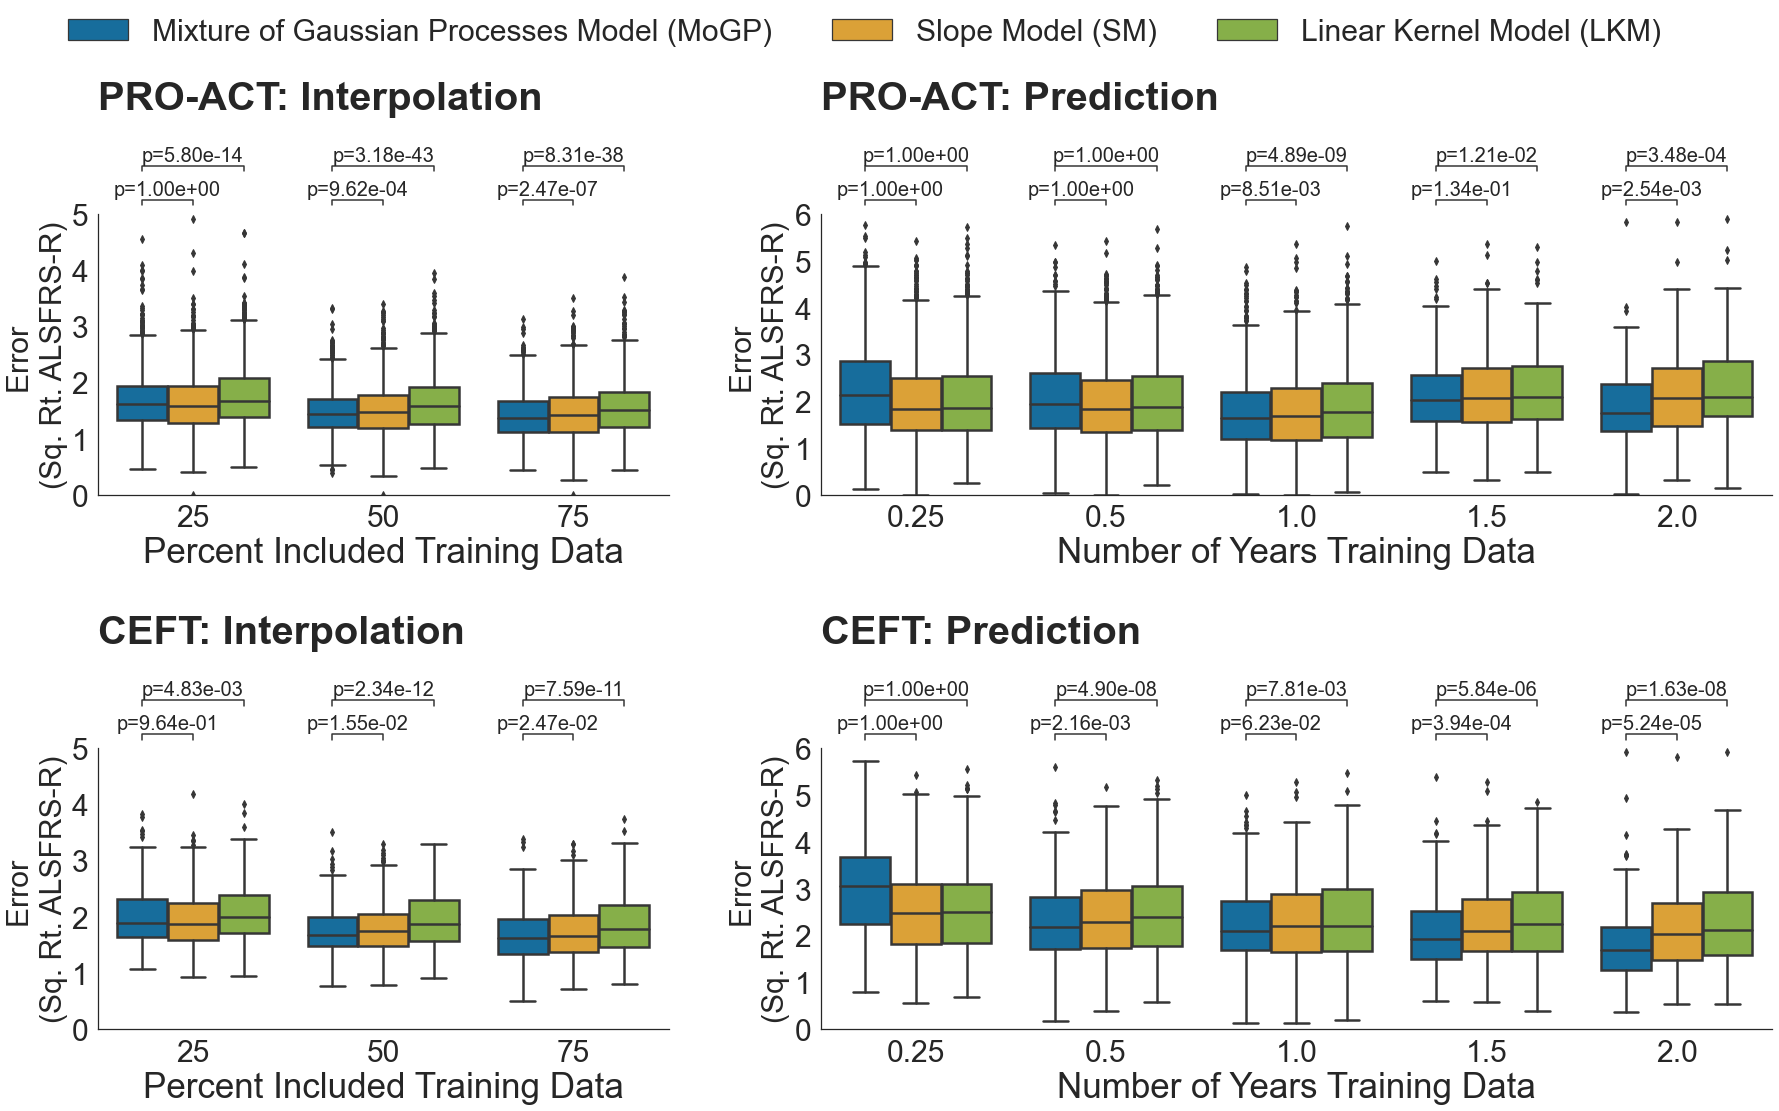

In [11]:
# Square Root Version
yticks_5 = [0,1,2,3,4,5]
yticks_10 = [0,1,2,3,4,5,6]

proact_sparse_err_merge['err_norm']=np.sqrt(proact_sparse_err_merge['err'])
proact_pred_err_merge['err_norm']=np.sqrt(proact_pred_err_merge['err'])
ceft_sparse_err_merge['err_norm']=np.sqrt(ceft_sparse_err_merge['err'])
ceft_pred_err_merge['err_norm']=np.sqrt(ceft_pred_err_merge['err'])

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 5/3], 'wspace':0.2, 'hspace':0.9}, figsize=(30, 15))
curax_1, handles, labels = plot_bars_task(axs.flat[0], proact_sparse_err_merge, 'err_norm', 'Percent Included Training Data', axtitle='PRO-ACT: Interpolation', ylim=[0, 5], yticks=yticks_5, legend_labels=legend_labels, col_palette=col_palette)
_ = curax_1.legend(handles,  labels, frameon=False, loc='lower left', bbox_to_anchor=(-0.1, 1.5), ncol=3, fontsize=30) 
curax_2, handles, labels = plot_bars_task(axs.flat[1], proact_pred_err_merge, 'err_norm', 'Number of Years Training Data', axtitle='PRO-ACT: Prediction', ylim=[0, 6], yticks=yticks_10, legend_labels=legend_labels, col_palette=col_palette)
_, _, _ = plot_bars_task(axs.flat[2], ceft_sparse_err_merge, 'err_norm', 'Percent Included Training Data', axtitle='CEFT: Interpolation', ylim=[0, 5], yticks=yticks_5, legend_labels=legend_labels, col_palette=col_palette)
_, _, _ = plot_bars_task(axs.flat[3], ceft_pred_err_merge, 'err_norm', 'Number of Years Training Data', axtitle='CEFT: Prediction', ylim=[0, 6], yticks=yticks_10, legend_labels=legend_labels, col_palette=col_palette)

# Save figure
fig.savefig('reports/fig_mogp_pred_sparse_boxplot.pdf', bbox_inches='tight')

In [12]:
#  View N at timepoints
proact_sparse_err_merge.groupby(['task_num', 'seed', 'type']).size() #A
proact_pred_err_merge.groupby(['task_num', 'seed', 'type']).size() #B
ceft_sparse_err_merge.groupby(['task_num', 'seed', 'type']).size() #C
ceft_pred_err_merge.groupby(['task_num', 'seed', 'type']).size() #D


task_num  seed  type  
25        0.0   rbf       1327
          4.0   linear    1327
50        1.0   linear    1327
                rbf       1327
75        1.0   rbf       1327
          2.0   linear    1327
dtype: int64

task_num  seed  type  
0.25      1.0   linear    2786
          2.0   rbf       2786
0.5       3.0   linear    2465
          4.0   rbf       2465
1.0       2.0   linear    1379
          3.0   rbf       1379
1.5       2.0   rbf        261
          3.0   linear     261
2.0       2.0   rbf        135
          4.0   linear     135
dtype: int64

task_num  seed  type  
25        2.0   linear    228
                rbf       228
50        0.0   linear    228
          1.0   rbf       228
75        4.0   linear    228
                rbf       228
dtype: int64

task_num  seed  type  
0.25      0.0   linear    453
                rbf       453
0.5       2.0   linear    437
                rbf       437
1.0       0.0   linear    323
          2.0   rbf       323
1.5       4.0   linear    215
                rbf       215
2.0       3.0   linear    130
          4.0   rbf       130
dtype: int64

## Supplement Figure 2:  Number of clusters in MAP for prediction/interpolation models

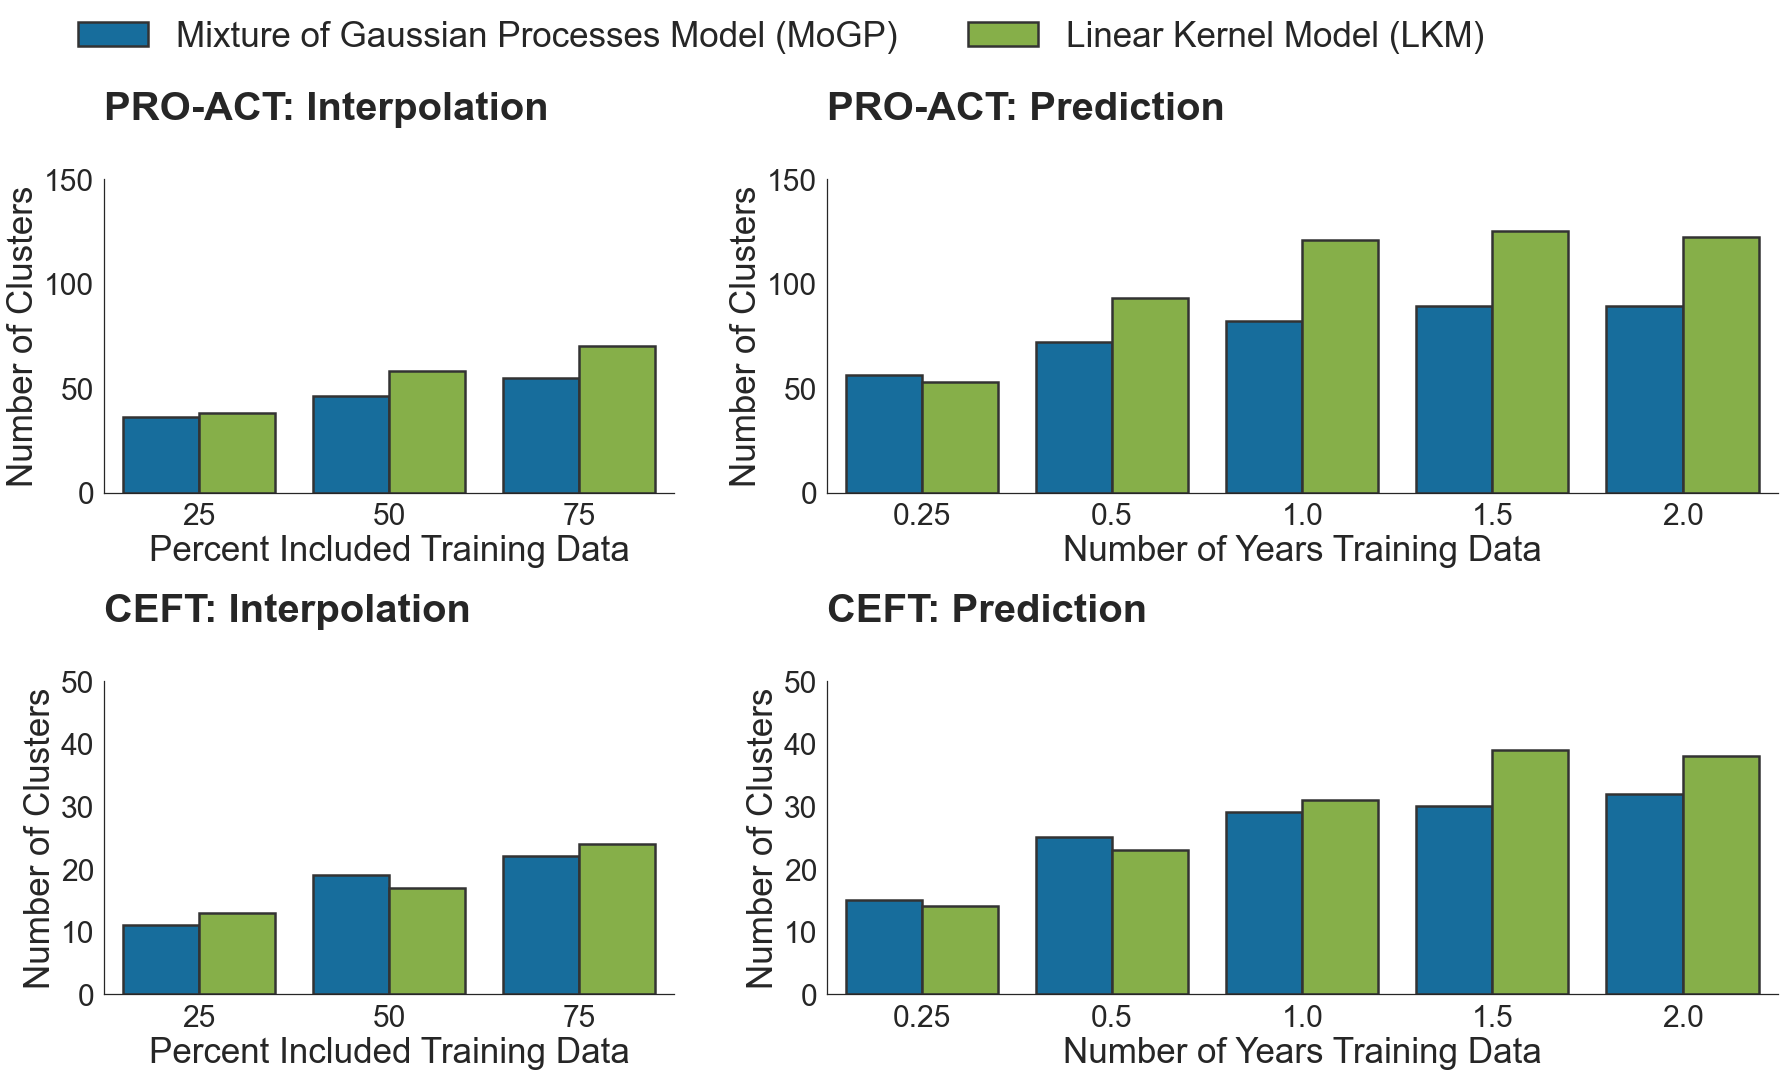

In [13]:
col_palette_cn = ['#176D9C', '#86AF49']  #Set colors to match prior figure

ylim_sparse_pro = [0,150]
ylim_pred_pro = [0,150]
ylim_sparse_cef = [0,50]
ylim_pred_cef = [0,50]

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 5/3], 'wspace': 0.2, 'hspace': 0.6}, figsize=(30, 15))
curax, handles, labels = plot_bars_cn(axs.flat[0], proact_sparse_cn_merge, 'num_clust', 'Percent Included Training Data', legend_labels=legend_labels_cn, axtitle='PRO-ACT: Interpolation', ylim=ylim_sparse_pro, col_palette=col_palette_cn)
_ = curax.legend(handles, labels, loc='lower left', bbox_to_anchor=(-0.1, 1.3), ncol=2)
curax, handles, labels = plot_bars_cn(axs.flat[1], proact_pred_cn_merge, 'num_clust', 'Number of Years Training Data', legend_labels=legend_labels_cn, axtitle='PRO-ACT: Prediction', ylim=ylim_pred_pro, col_palette=col_palette_cn)
_, _, _ = plot_bars_cn(axs.flat[2], ceft_sparse_cn_merge, 'num_clust', 'Percent Included Training Data', legend_labels=legend_labels_cn, axtitle='CEFT: Interpolation', ylim=ylim_sparse_cef, col_palette=col_palette_cn)
_, _, _ = plot_bars_cn(axs.flat[3], ceft_pred_cn_merge, 'num_clust', 'Number of Years Training Data', legend_labels=legend_labels_cn, axtitle='CEFT: Prediction', ylim=ylim_pred_cef, col_palette=col_palette_cn)

# Save figure
fig.savefig('reports/supp_fig_mogp_pred_sparse_clust_num.pdf', bbox_inches='tight')

## Dataframes for prediction/interpolation experiments

Note: Minor variances expected with subsequent runs in GPy predictions

In [14]:
print('proact-sparsity')
proact_sparse_err_merge.groupby(['type', 'task_num']).mean().round(2)
print('ceft-sparsity')
ceft_sparse_err_merge.groupby(['type', 'task_num']).mean().round(2)
print('difference-sparsity')
diff_calc = proact_sparse_err_merge.groupby(['type', 'task_num']).mean().loc['rbf']-proact_sparse_err_merge.groupby(['type', 'task_num']).mean().loc['slope']
diff_calc.round(2)

# Dataframes for sparsity experiments
print('proact-pred')
proact_pred_err_merge.groupby(['type', 'task_num']).mean().round(2)
print('ceft-pred')
ceft_pred_err_merge.groupby(['type', 'task_num']).mean().round(2)
print('difference-pred')
diff_calc = proact_pred_err_merge.groupby(['type', 'task_num']).mean().loc['rbf']-proact_pred_err_merge.groupby(['type', 'task_num']).mean().loc['slope']
diff_calc.round(2)

proact-sparsity


err  seed  best_ll  err_norm
type    task_num                               
gp      25        3.59   NaN      NaN      1.78
        50        2.73   NaN      NaN      1.57
        75        2.32   NaN      NaN      1.44
linear  25        3.43   4.0 -2562.46      1.77
        50        2.92   1.0 -3833.63      1.64
        75        2.64   2.0 -4081.39      1.55
lme     25        3.09   NaN      NaN      1.68
        50        2.70   NaN      NaN      1.57
        75        2.48   NaN      NaN      1.50
quad    25        3.76   NaN      NaN      1.76
        50        2.16   NaN      NaN      1.40
        75        1.93   NaN      NaN      1.33
rbf     25        3.09   0.0 -1902.03      1.68
        50        2.35   1.0 -1852.35      1.48
        75        2.13   1.0 -1228.56      1.40
sigmoid 25        3.18   NaN      NaN      1.70
        50        2.19   NaN      NaN      1.43
        75        1.95   NaN      NaN      1.35
slope   25        2.99   NaN      NaN      1.65
        50        2.51   NaN      NaN      1.52
        75        2.35   NaN      NaN      1.46

ceft-sparsity


err  seed  best_ll  err_norm
type    task_num                               
gp      25        4.48   NaN      NaN      2.03
        50        3.52   NaN      NaN      1.81
        75        3.00   NaN      NaN      1.66
linear  25        4.61   2.0  -524.63      2.08
        50        4.13   0.0  -905.05      1.97
        75        3.82   4.0 -1131.05      1.87
lme     25        4.28   NaN      NaN      2.00
        50        3.76   NaN      NaN      1.88
        75        3.45   NaN      NaN      1.78
quad    25        4.51   NaN      NaN      1.99
        50        2.95   NaN      NaN      1.66
        75        2.61   NaN      NaN      1.56
rbf     25        4.37   2.0  -382.49      2.02
        50        3.19   1.0  -504.39      1.74
        75        2.99   4.0  -543.20      1.67
sigmoid 25        3.71   NaN      NaN      1.86
        50        2.79   NaN      NaN      1.63
        75        2.51   NaN      NaN      1.54
slope   25        4.15   NaN      NaN      1.96
        50        3.54   NaN      NaN      1.82
        75        3.27   NaN      NaN      1.73

difference-sparsity


,err,seed,best_ll,err_norm
task_num,,,,
25,0.10,NaN,NaN,0.03
50,-0.17,NaN,NaN,-0.04
75,-0.22,NaN,NaN,-0.05


proact-pred


err  seed   best_ll  err_norm
type    task_num                                 
gp      0.25       5.96   NaN       NaN      2.24
        0.5        5.47   NaN       NaN      2.15
        1.0        3.84   NaN       NaN      1.76
        1.5        4.81   NaN       NaN      2.04
        2.0        4.68   NaN       NaN      1.99
linear  0.25       4.77   1.0  -4862.94      2.02
        0.5        4.71   3.0  -7217.85      2.01
        1.0        4.21   2.0  -9701.65      1.87
        1.5        5.86   3.0 -10461.08      2.26
        2.0        6.18   4.0 -10359.72      2.29
lme     0.25       4.62   NaN       NaN      1.99
        0.5        4.54   NaN       NaN      1.97
        1.0        4.13   NaN       NaN      1.85
        1.5        5.82   NaN       NaN      2.25
        2.0        6.13   NaN       NaN      2.29
quad    0.25      15.56   NaN       NaN      3.23
        0.5        6.70   NaN       NaN      2.29
        1.0        4.25   NaN       NaN      1.79
        1.5        6.30   NaN       NaN      2.22
        2.0        6.14   NaN       NaN      2.24
rbf     0.25       5.92   2.0  -4176.12      2.25
        0.5        4.91   4.0  -5132.45      2.06
        1.0        3.67   3.0  -4745.68      1.75
        1.5        5.14   2.0  -4112.83      2.11
        2.0        4.40   2.0  -4008.08      1.93
sigmoid 0.25       7.50   NaN       NaN      2.53
        0.5        4.88   NaN       NaN      2.07
        1.0        3.28   NaN       NaN      1.68
        1.5        3.74   NaN       NaN      1.81
        2.0        3.37   NaN       NaN      1.72
slope   0.25       4.62   NaN       NaN      1.99
        0.5        4.46   NaN       NaN      1.95
        1.0        3.89   NaN       NaN      1.79
        1.5        5.54   NaN       NaN      2.19
        2.0        5.68   NaN       NaN      2.19

ceft-pred


err  seed  best_ll  err_norm
type    task_num                                
gp      0.25       9.44   NaN      NaN      2.90
        0.5        8.07   NaN      NaN      2.69
        1.0        6.04   NaN      NaN      2.30
        1.5        5.09   NaN      NaN      2.12
        2.0        4.49   NaN      NaN      1.94
linear  0.25       7.26   0.0  -760.82      2.55
        0.5        6.94   2.0 -1196.43      2.47
        1.0        6.34   0.0 -1642.83      2.33
        1.5        6.21   4.0 -1908.82      2.33
        2.0        6.12   3.0 -2106.49      2.29
lme     0.25       7.09   NaN      NaN      2.52
        0.5        6.54   NaN      NaN      2.40
        1.0        6.21   NaN      NaN      2.32
        1.5        6.31   NaN      NaN      2.36
        2.0        5.94   NaN      NaN      2.26
quad    0.25      35.17   NaN      NaN      5.19
        0.5       12.90   NaN      NaN      3.12
        1.0        8.38   NaN      NaN      2.56
        1.5        6.89   NaN      NaN      2.35
        2.0        5.92   NaN      NaN      2.19
rbf     0.25       9.88   0.0  -671.97      3.00
        0.5        5.93   2.0 -1104.75      2.29
        1.0        5.62   2.0 -1110.93      2.23
        1.5        4.80   4.0 -1175.01      2.05
        2.0        4.13   4.0 -1133.40      1.84
sigmoid 0.25      10.54   NaN      NaN      3.05
        0.5        6.41   NaN      NaN      2.37
        1.0        4.74   NaN      NaN      2.03
        1.5        3.90   NaN      NaN      1.86
        2.0        3.29   NaN      NaN      1.68
slope   0.25       7.17   NaN      NaN      2.53
        0.5        6.53   NaN      NaN      2.39
        1.0        6.12   NaN      NaN      2.30
        1.5        5.91   NaN      NaN      2.28
        2.0        5.52   NaN      NaN      2.17

difference-pred


,err,seed,best_ll,err_norm
task_num,,,,
0.25,1.30,NaN,NaN,0.26
0.5,0.46,NaN,NaN,0.10
1.0,-0.22,NaN,NaN,-0.04
1.5,-0.41,NaN,NaN,-0.07
2.0,-1.28,NaN,NaN,-0.26


## Supplement: Vary alpha for prediction results

In [15]:
rmse_err_path = Path('data/model_data/2_sparsity_prediction/prediction/results/rmse')


In [16]:
# Load all data matrices
# exp_path = Path('data/model_data/2_sparsity_prediction')
base_mods = ['rbf', 'linear']
alph_list = ['0.1', '0.5', '2.0', '10.0']

file_ext_dict = {'prediction':'predict'}
err_store_dict = {}
cur_exp = 'prediction'
cur_proj = 'ceft'
for cur_alpha in alph_list:
    tmp_store_dict = {}
    for cur_mod_type in base_mods: #change to rbf, linear
        tmp_store_dict[cur_mod_type]=joblib.load(rmse_err_path / '{}_{}_{}_{}_rmse_err.pkl'.format(file_ext_dict[cur_exp], cur_proj, cur_mod_type, cur_alpha))
    err_store_dict['{}_{}_alpha{}'.format(cur_proj, file_ext_dict[cur_exp], cur_alpha)] = tmp_store_dict

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
0.5_Mixture of Gaussian Processes Model (MoGP) v.s. 0.5_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=8.616e-04 stat=3.957e+04
Using zero_method  wilcox
0.25_Mixture of Gaussian Processes Model (MoGP) v.s. 0.25_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=1.000e+00 stat=8.779e+04
Using zero_method  wilcox
1.0_Mixture of Gaussian Processes Model (MoGP) v.s. 1.0_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=4.936e-04 stat=2.063e+04
Using zero_method  wilcox
1.5_Mixture of Gaussian Processes Model (MoGP) v.s. 1.5_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=5.146e-09 stat=6.381e+03
Using zero_method  wilcox
2.0_Mixture of Gaussian Processes Model (MoGP) v.s. 2.0_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val

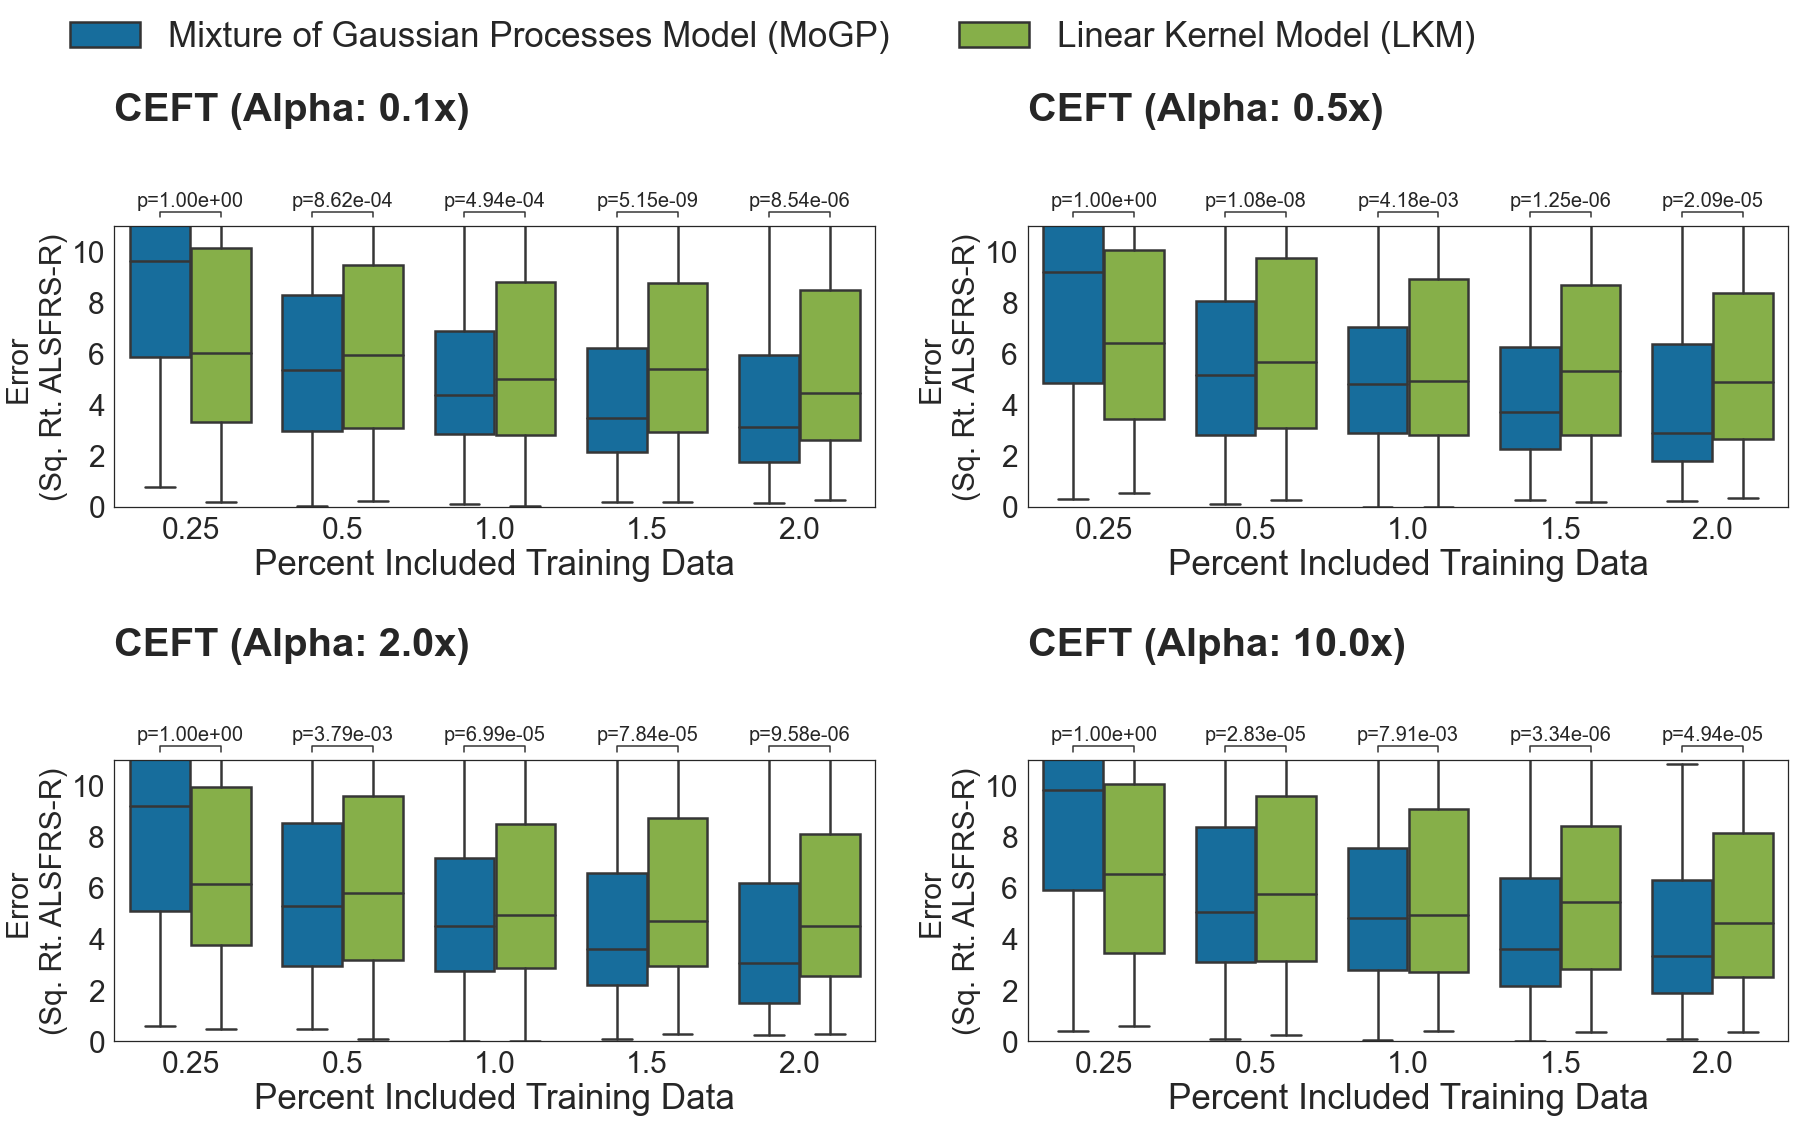

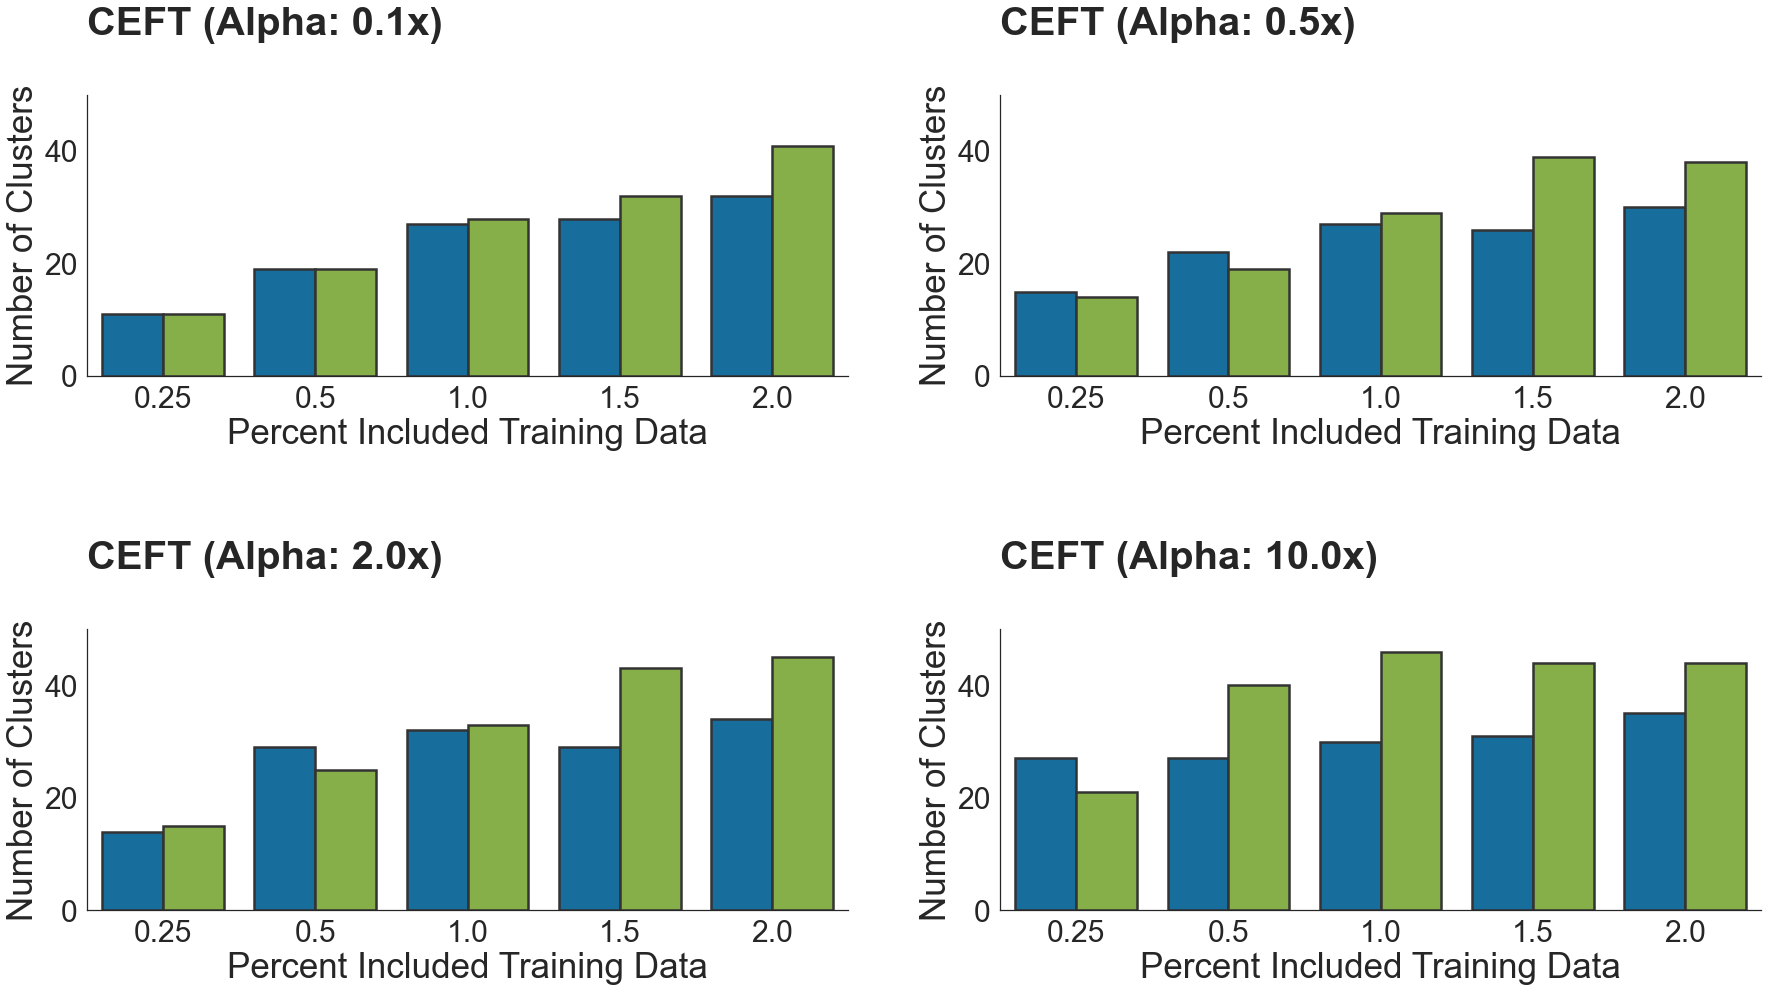

In [17]:
col_palette_cn = ['#176D9C', '#86AF49']  #Set colors to match prior figure


# Plot Figure
ylim_pred_cef = [0,50]
yticks_10 = [0, 2, 4, 6, 8, 10]

fig, axs = plt.subplots(2, 2, gridspec_kw={'wspace': 0.2, 'hspace': 0.9}, figsize=(30, 15))
fig_cn, axs_cn = plt.subplots(2, 2, gridspec_kw={'wspace': 0.2, 'hspace': 0.9}, figsize=(30, 15))


for j, cur_alpha in enumerate(alph_list):
    a_err_merge, a_sparse_cn_merge = gen_err_merge(err_store_dict['ceft_predict_alpha{}'.format(cur_alpha)])
    _, _, _ = plot_bars_task(axs.flat[j], a_err_merge, 'err', 'Percent Included Training Data', axtitle='CEFT (Alpha: {}x)'.format(cur_alpha), ylim=[0, 11], yticks=yticks_10, legend_labels=legend_labels, col_palette=col_palette_cn)
    _, handles, labels = plot_bars_cn(axs_cn.flat[j], a_sparse_cn_merge, 'num_clust', 'Percent Included Training Data', legend_labels=legend_labels_cn, axtitle='CEFT (Alpha: {}x)'.format(cur_alpha), ylim=ylim_pred_cef, col_palette=col_palette_cn)

_ = axs.flat[0].legend(handles, labels, loc='lower left', bbox_to_anchor=(-0.1, 1.5), ncol=2)

    
# # Save figure
fig.savefig('reports/supp_fig_mogp_pred_varyalpha_err.pdf', bbox_inches='tight')
fig_cn.savefig('reports/supp_fig_mogp_pred_varyalpha_clustnum.pdf', bbox_inches='tight')

## Supplement add extra baselines

In [18]:
legend_labels_extend={'rbf': 'Mixture of Gaussian Processes Model (MoGP)', 'linear':'Linear Kernel Model (LKM)', 'slope':'Slope Model (SM)',
              'sigmoid':'Sigmoidal Model (SG)', 'lme': 'Linear Mixed Model (LME)', 'gp': 'Patient-specific GP (PGP)', 
                     'quad': 'Quadratic Model (Q)'}


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
50_Mixture of Gaussian Processes Model (MoGP) v.s. 50_Slope Model (SM): Wilcoxon test (paired samples), P_val=2.287e-03 stat=4.010e+05
Using zero_method  wilcox
25_Mixture of Gaussian Processes Model (MoGP) v.s. 25_Slope Model (SM): Wilcoxon test (paired samples), P_val=9.999e-01 stat=4.928e+05
Using zero_method  wilcox
75_Mixture of Gaussian Processes Model (MoGP) v.s. 75_Slope Model (SM): Wilcoxon test (paired samples), P_val=2.330e-06 stat=3.766e+05
Using zero_method  wilcox
50_Mixture of Gaussian Processes Model (MoGP) v.s. 50_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=7.127e-43 stat=2.496e+05
Using zero_method  wilcox
25_Mixture of Gaussian Processes Model (MoGP) v.s. 25_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=1.127e-13 stat=3.382e+05
Using zero_me

Using zero_method  wilcox
1.5_Mixture of Gaussian Processes Model (MoGP) v.s. 1.5_Linear Mixed Model (LME): Wilcoxon test (paired samples), P_val=1.688e-02 stat=1.450e+04
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
50_Mixture of Gaussian Processes Model (MoGP) v.s. 50_Slope Model (SM): Wilcoxon test (paired samples), P_val=1.589e-02 stat=1.091e+04
Using zero_method  wilcox
25_Mixture of Gaussian Processes Model (MoGP) v.s. 25_Slope Model (SM): Wilcoxon test (paired samples), P_val=9.750e-01 stat=1.501e+04
Using zero_method  wilcox
75_Mixture of Gaussian Processes Model (MoGP) v.s. 75_Slope Model (SM): Wilcoxon test (paired samples), P_val=3.286e-02 stat=1.122e+04
Using zero_method  wilcox
50_Mixture of Gaussian Processes Model (MoGP) v.s. 50_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=2.972e-12 stat=6.192e+03
Using zero_m

Using zero_method  wilcox
1.0_Mixture of Gaussian Processes Model (MoGP) v.s. 1.0_Linear Mixed Model (LME): Wilcoxon test (paired samples), P_val=6.464e-02 stat=2.362e+04
Using zero_method  wilcox
1.5_Mixture of Gaussian Processes Model (MoGP) v.s. 1.5_Linear Mixed Model (LME): Wilcoxon test (paired samples), P_val=8.083e-06 stat=7.672e+03


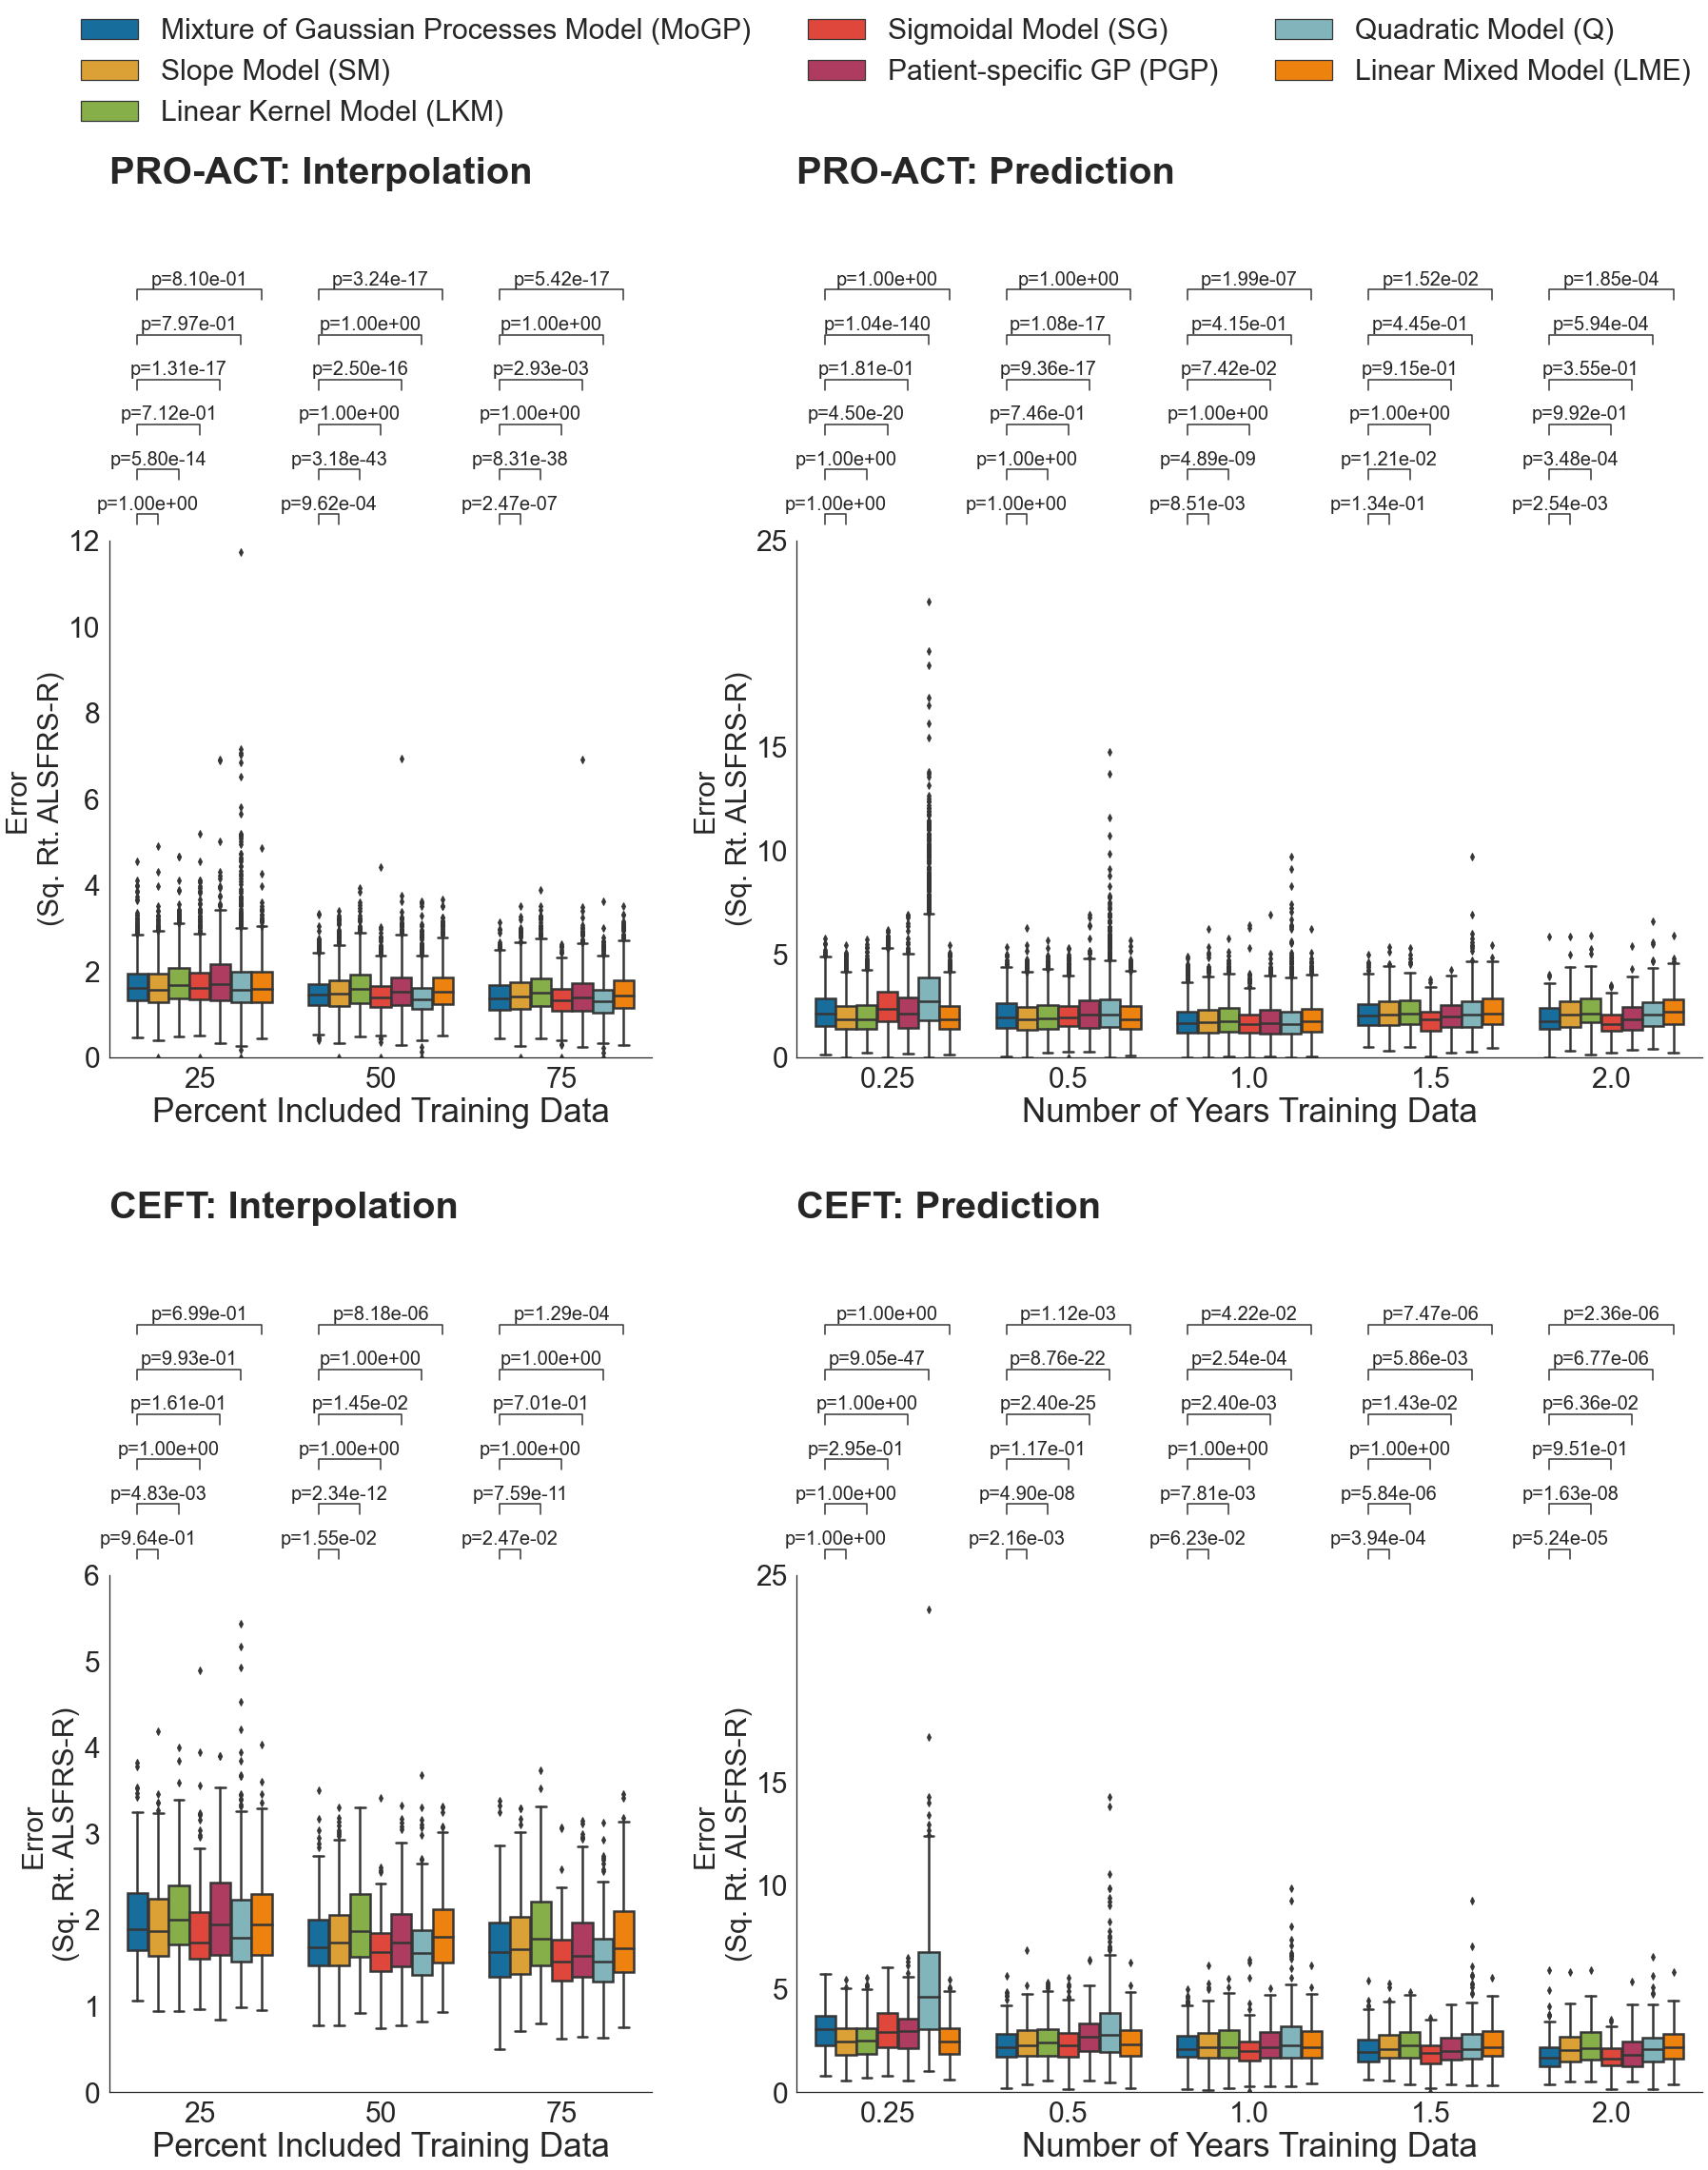

In [19]:
# Plot Figure
yticks_12 = [0, 2, 4, 6, 8, 10, 12]
yticks_25 = [0,5,10,15,25]
yticks_6 = [0,1,2,3,4,5,6]

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 5/3], 'wspace':0.2, 'hspace':1}, figsize=(30, 30))
curax_1, handles, labels = plot_bars_task(axs.flat[0], proact_sparse_err_merge, 'err_norm', 'Percent Included Training Data', axtitle='PRO-ACT: Interpolation', ylim=[0, max(yticks_12)], yticks=yticks_12, legend_labels=legend_labels_extend, col_palette=col_palette, axpad=375)
_ = curax_1.legend(handles,  labels, frameon=False, loc='lower left', bbox_to_anchor=(-0.1, 1.75), ncol=3, fontsize=30, bbox_transform=curax_1.transAxes) 
curax_2, handles, labels = plot_bars_task(axs.flat[1], proact_pred_err_merge, 'err_norm', 'Number of Years Training Data', axtitle='PRO-ACT: Prediction', ylim=[0, max(yticks_25)], yticks=yticks_25, legend_labels=legend_labels_extend, col_palette=col_palette, axpad=375)
_, _, _ = plot_bars_task(axs.flat[2], ceft_sparse_err_merge, 'err_norm', 'Percent Included Training Data', axtitle='CEFT: Interpolation', ylim=[0, max(yticks_6)], yticks=yticks_6, legend_labels=legend_labels_extend, col_palette=col_palette, axpad=375)
_, _, _ = plot_bars_task(axs.flat[3], ceft_pred_err_merge, 'err_norm', 'Number of Years Training Data', axtitle='CEFT: Prediction', ylim=[0, max(yticks_25)], yticks=yticks_25, legend_labels=legend_labels_extend, col_palette=col_palette, axpad=375)

# Save figure
fig.savefig('reports/supp_fig_mogp_pred_sparse_addl_baselines_boxplot.pdf', bbox_inches='tight')


## Supplement: Additional datasets - AALS, EMORY, NATHIST

In [20]:
# Load all data matrices
exp_path = Path('data/model_data/2_sparsity_prediction')
base_mods = ['rbf', 'slope', 'linear']

file_ext_dict = {'prediction': 'predict', 'sparsity':'sparse'}
err_store_dict = {}

for cur_exp in ['prediction']:        
    rmse_err_path = exp_path / cur_exp / 'results' / 'rmse' 
    for cur_proj in ['aals', 'emory', 'nathist']:
        tmp_store_dict = {}
        for cur_mod_type in base_mods: #change to rbf, linear
            tmp_store_dict[cur_mod_type]=joblib.load(rmse_err_path / '{}_{}_{}_rmse_err.pkl'.format(file_ext_dict[cur_exp], cur_proj, cur_mod_type))
        err_store_dict['{}_{}'.format(cur_proj, file_ext_dict[cur_exp])] = tmp_store_dict

for cur_exp in ['sparsity']:        
    rmse_err_path = exp_path / cur_exp / 'results' / 'rmse' 
    for cur_proj in ['nathist']:
        tmp_store_dict = {}
        for cur_mod_type in base_mods: #change to rbf, linear
            tmp_store_dict[cur_mod_type]=joblib.load(rmse_err_path / '{}_{}_{}_rmse_err.pkl'.format(file_ext_dict[cur_exp], cur_proj, cur_mod_type))
        err_store_dict['{}_{}'.format(cur_proj, file_ext_dict[cur_exp])] = tmp_store_dict

In [21]:
aals_pred_err_merge, aals_pred_cn_merge = gen_err_merge(err_store_dict['aals_predict'])
emory_pred_err_merge, emory_pred_cn_merge = gen_err_merge(err_store_dict['emory_predict'])
nathist_pred_err_merge, nathist_pred_cn_merge = gen_err_merge(err_store_dict['nathist_predict'])
nathist_sparse_err_merge, nathist_sparse_cn_merge = gen_err_merge(err_store_dict['nathist_sparse'])

In [22]:
ceft_pred_err_merge.groupby(['task_num', 'seed', 'type']).size()
proact_pred_err_merge.groupby(['task_num', 'seed', 'type']).size()

aals_pred_err_merge.groupby(['task_num', 'seed', 'type']).size()
emory_pred_err_merge.groupby(['task_num', 'seed', 'type']).size()

task_num  seed  type  
0.25      0.0   linear    453
                rbf       453
0.5       2.0   linear    437
                rbf       437
1.0       0.0   linear    323
          2.0   rbf       323
1.5       4.0   linear    215
                rbf       215
2.0       3.0   linear    130
          4.0   rbf       130
dtype: int64

task_num  seed  type  
0.25      1.0   linear    2786
          2.0   rbf       2786
0.5       3.0   linear    2465
          4.0   rbf       2465
1.0       2.0   linear    1379
          3.0   rbf       1379
1.5       2.0   rbf        261
          3.0   linear     261
2.0       2.0   rbf        135
          4.0   linear     135
dtype: int64

task_num  seed  type  
0.25      0.0   linear    341
          4.0   rbf       341
0.5       4.0   linear    340
                rbf       340
1.0       2.0   linear    257
          4.0   rbf       257
1.5       0.0   linear    138
          1.0   rbf       138
2.0       2.0   rbf        84
          4.0   linear     84
dtype: int64

task_num  seed  type  
0.25      1.0   rbf       282
          4.0   linear    282
0.5       1.0   linear    278
                rbf       278
1.0       0.0   linear    222
          1.0   rbf       222
1.5       0.0   linear    152
          3.0   rbf       152
2.0       0.0   rbf        92
          2.0   linear     92
dtype: int64

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
1.0_Mixture of Gaussian Processes Model (MoGP) v.s. 1.0_Slope Model (SM): Wilcoxon test (paired samples), P_val=9.150e-01 stat=1.821e+04
Using zero_method  wilcox
1.5_Mixture of Gaussian Processes Model (MoGP) v.s. 1.5_Slope Model (SM): Wilcoxon test (paired samples), P_val=8.738e-01 stat=5.334e+03
Using zero_method  wilcox
2.0_Mixture of Gaussian Processes Model (MoGP) v.s. 2.0_Slope Model (SM): Wilcoxon test (paired samples), P_val=7.539e-01 stat=1.939e+03
Using zero_method  wilcox
0.25_Mixture of Gaussian Processes Model (MoGP) v.s. 0.25_Slope Model (SM): Wilcoxon test (paired samples), P_val=1.000e+00 stat=4.182e+04
Using zero_method  wilcox
0.5_Mixture of Gaussian Processes Model (MoGP) v.s. 0.5_Slope Model (SM): Wilcoxon test (paired samples), P_val=1.000e+00 stat=3.996e+04
Using zero_method  

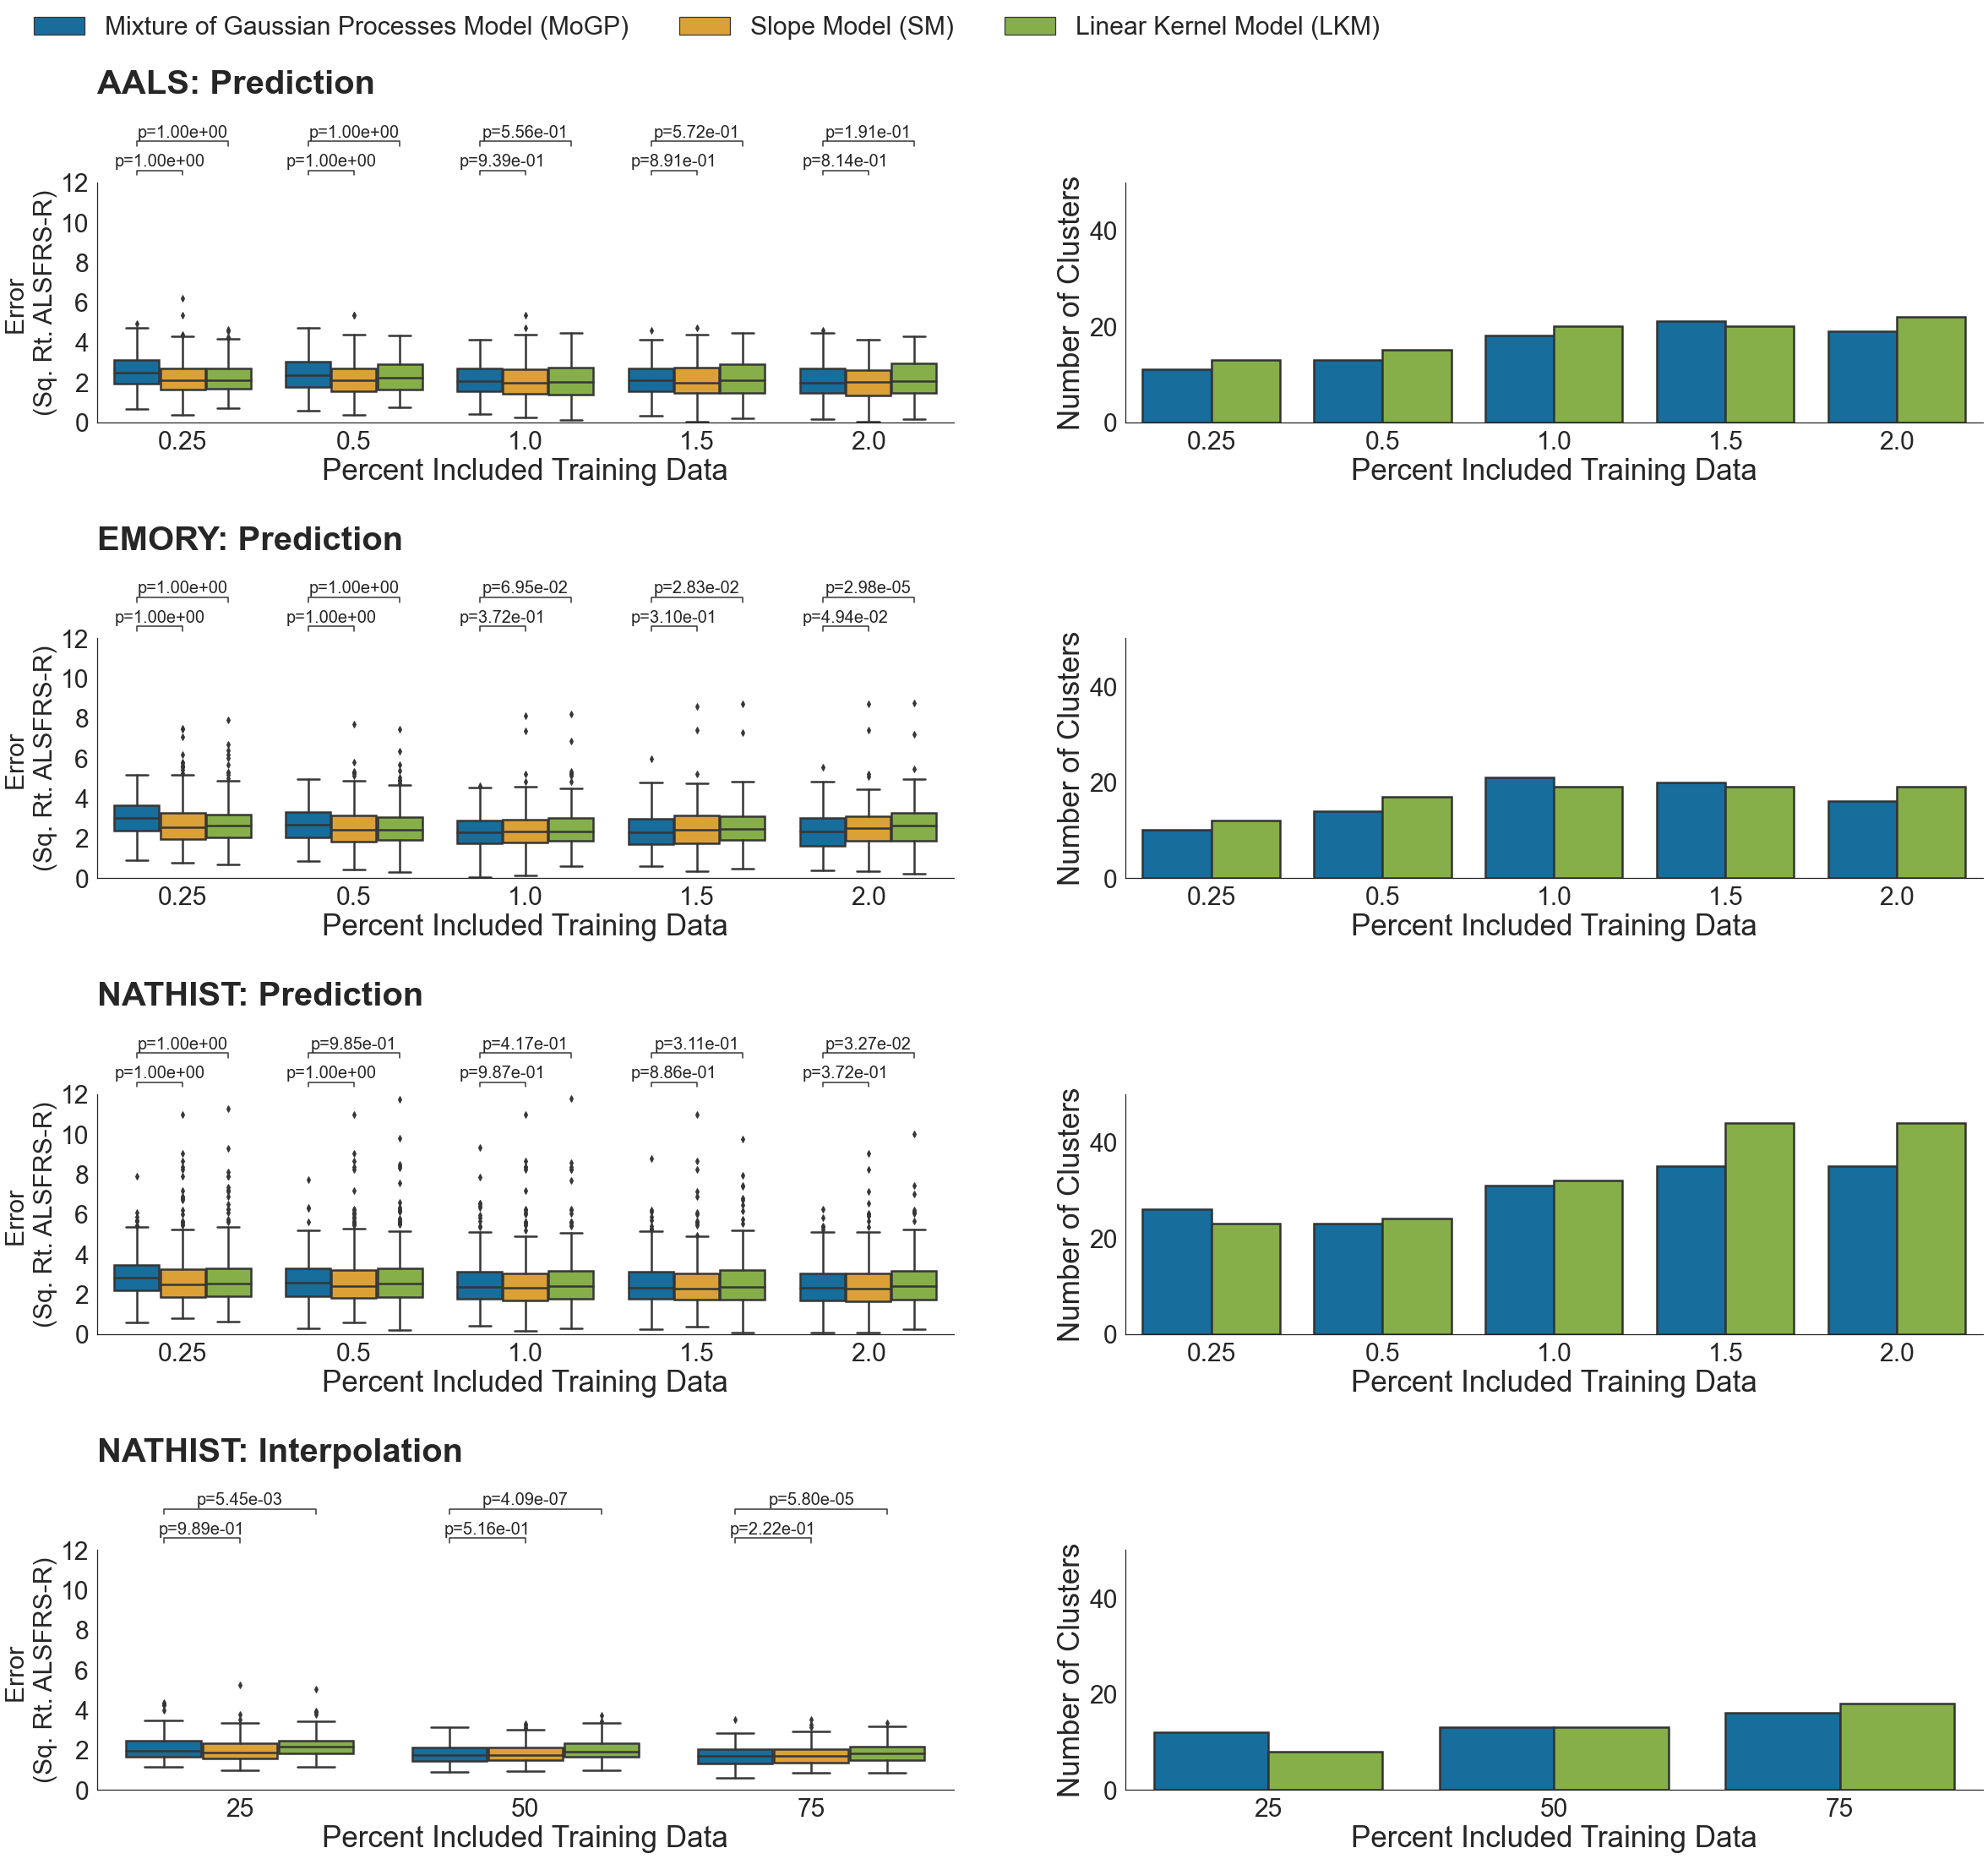

In [24]:
label_projs = {'aals':'AALS', 'emory':'EMORY', 'nathist':'NATHIST'}
col_palette_cn = ['#176D9C', '#86AF49']  #Set colors to match prior figure


# Plot Figure
ylim_pred_cef = [0,50]
yticks_10 = [0, 2, 4, 6, 8, 10, 12]
fig, axs = plt.subplots(4, 2, gridspec_kw={'hspace': 0.9}, figsize=(40, 35))

# Predict plots
for j, cur_proj in enumerate(['aals', 'emory', 'nathist']):
    a_err_merge, a_sparse_cn_merge = gen_err_merge(err_store_dict['{}_predict'.format(cur_proj)])
    a_err_merge['err_norm']=np.sqrt(a_err_merge['err'])
    _, handles, labels = plot_bars_task(axs[j,0], a_err_merge, 'err_norm', 'Percent Included Training Data', axtitle='{}: Prediction'.format(label_projs[cur_proj]), ylim=[0, 11], yticks=yticks_10, legend_labels=legend_labels, col_palette=col_palette)
    _, _, _ = plot_bars_cn(axs[j,1], a_sparse_cn_merge, 'num_clust', 'Percent Included Training Data', legend_labels=legend_labels_cn, axtitle='', ylim=ylim_pred_cef, col_palette=col_palette_cn)

#Sparsity plots - nathist
nathist_sparse_err_merge['err_norm']=np.sqrt(nathist_sparse_err_merge['err'])
_, handles, labels = plot_bars_task(axs[-1,0], nathist_sparse_err_merge, 'err_norm', 'Percent Included Training Data', axtitle='{}: Interpolation'.format(label_projs[cur_proj]), ylim=[0, 11], yticks=yticks_10, legend_labels=legend_labels, col_palette=col_palette)
_, _, _ = plot_bars_cn(axs[-1,1], nathist_sparse_cn_merge, 'num_clust', 'Percent Included Training Data', legend_labels=legend_labels_cn, axtitle='', ylim=ylim_pred_cef, col_palette=col_palette_cn)
    
_ = axs.flat[0].legend(handles,  labels, frameon=False, loc='lower left', bbox_to_anchor=(-0.1, 1.5), ncol=3, fontsize=30) 
    
# # Save figure
fig.savefig('reports/supp_fig_mogp_pred_sparse_addlproj_box.pdf', bbox_inches='tight')